In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

LOCAL = False
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE="/wynton/group/ahituv/biomarin/results"

In [2]:
MPRA = os.path.join(PATH, "delta_rank.csv")
#MPRA= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
FASTA = os.path.join(PATH, "library_2", "Design", "biomarin-lib2-hg38-final.fasta")
META_DATA= os.path.join(PATH, "lib2.meta_data.tsv")
TILE_BED = os.path.join(PATH, "lib2.processed.bed")
ENH_BED = os.path.join(PATH,'lib2.processed.merged.bed')
GREAT_GENE_TSV = os.path.join(PATH, "GREAT", f"region2gene_lib2hg38.tsv")
DELTA_ACTIVITY= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
DELTA_ACTIVITY_Z= os.path.join(PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
SIG_ACTIVITY_Z= os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")

import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [3]:
meta = pd.read_csv(META_DATA, sep='\t')
merge = pd.read_csv(ENH_BED, sep='\t')
delta = pd.read_csv(DELTA_ACTIVITY, sep='\t')

merge.head()

,#chr,start.tile,end.tile,coor,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
0,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,0
1,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,1
2,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,2
3,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,3
4,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893:+|Pos...,Background seq2 chr1,244100624,244100893,Background seq2 chr1:244100624-244100893,enh.0,4


In [4]:
len(set(merge["enh.id"]))

1827

# load MPRA data

In [5]:
mpra = pd.read_csv(MPRA)
#mpra = mpra.rename(columns ={"delta.gaba-glut":"delta"})
print(mpra.shape)
mpra.head()

(35371, 5)


,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0


# evaluate GREAT

- get nearby coordinates using GREAT nearest 2 gene function

## load great annotations

In [6]:
GREAT_GENE = os.path.join(os.path.split(MPRA)[0], "GREAT", f"region2gene_lib2hg38.txt")

locus_dict = {}
with open(GREAT_GENE, "r") as reader:
    for line in reader:
        if "#" not in line and line !="\n":
            
            locus, genes = line.strip("\n").split("\t")  # split on tab to get gene name

            info = [locus]
            
            for n, i in enumerate(genes.split(",")):
                if i != "NONE":
                    gene, dist = i.strip(" ").split(" ")
                    dist = dist.strip("()")
                else:
                    gene, dist = "na", "na"
                
                locus_dict[f'{locus}-{n}'] = [locus, gene, dist]


vstack = np.vstack(locus_dict.values())

great = pd.DataFrame(vstack)
great.columns = ["coor", "gene", 'dist']
great = great.loc[great.dist!="na"]  # remove any elements w/ no genes
great.head()

/scratch/fongsl/ipykernel_2066638/3571604425.py:22: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vstack = np.vstack(locus_dict.values())


,coor,gene,dist
0,chr1:101316025-101316295,S1PR1,+79272
1,chr1:101316025-101316295,OLFM3,+530813
2,chr1:101316045-101316315,S1PR1,+79292
3,chr1:101316045-101316315,OLFM3,+530793
4,chr1:101316065-101316335,S1PR1,+79312


# add GREAT annotations to fasta meta data

In [7]:
enh = pd.merge(great, meta)

# rename columns for merging with MPRA data
enh = enh.rename(columns ={"start":"start.tile",
                           "end":"end.tile"})

enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,strand,#chr,start.tile,end.tile
0,chr1:101316025-101316295,S1PR1,+79272,chr1:101316025-101316295,AGGACCGGATCAACTAGAGTCACCCCTGCTGTTCCCCGTAGGATGA...,False,NaN,NaN,NaN,NaN,+,chr1,101316025.0,101316295.0
1,chr1:101316025-101316295,OLFM3,+530813,chr1:101316025-101316295,AGGACCGGATCAACTAGAGTCACCCCTGCTGTTCCCCGTAGGATGA...,False,NaN,NaN,NaN,NaN,+,chr1,101316025.0,101316295.0
2,chr1:101316045-101316315,S1PR1,+79292,chr1:101316045-101316315,AGGACCGGATCAACTCCGTAGGATGACGCTGGTGTAAAAAGGTTAC...,False,NaN,NaN,NaN,NaN,+,chr1,101316045.0,101316315.0
3,chr1:101316045-101316315,OLFM3,+530793,chr1:101316045-101316315,AGGACCGGATCAACTCCGTAGGATGACGCTGGTGTAAAAAGGTTAC...,False,NaN,NaN,NaN,NaN,+,chr1,101316045.0,101316315.0
4,chr1:101316065-101316335,S1PR1,+79312,chr1:101316065-101316335,AGGACCGGATCAACTAAAAAGGTTACCGTTGCTTCAGTGGCCCTTG...,False,NaN,NaN,NaN,NaN,+,chr1,101316065.0,101316335.0


# add MPRA

In [8]:
enh = pd.merge(enh, mpra).drop_duplicates()

mpra.head()

,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0


In [9]:
enh = pd.merge(enh, delta).drop_duplicates()

# merge enhancer info w/ MPRA info

In [10]:
# add enhancer coordinate information
enh[["start.tile", "end.tile"]] = enh[["start.tile", "end.tile"]].astype(int)

enh = pd.merge(enh, merge,
               left_on=["#chr", "start.tile", "end.tile", "coor"],
               right_on=["#chr", "start.tile", "end.tile", "coor"])
enh = enh.sort_values(by=["#chr", "start.tile", "end.tile"])

enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,...,celltype_dif,gaba,glut,delta.gaba-glut,#chr.enh,start.enh,end.enh,enh.id,enh.name,tile.order
1678,chr1:1692002-1692272,CDK11B,-33125,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,False,0.525588,0.205703,0.319886,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,0
1679,chr1:1692002-1692272,SLC35E2B,+507,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,False,0.525588,0.205703,0.319886,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,0
1680,chr1:1692022-1692292,CDK11B,-33145,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,False,0.602023,0.072854,0.529169,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,1
1681,chr1:1692022-1692292,SLC35E2B,+487,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,False,0.602023,0.072854,0.529169,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,1
1682,chr1:1692042-1692312,CDK11B,-33165,chr1:1692042-1692312,AGGACCGGATCAACTAAAGTAGATTTCACTCCATTAAAGAAAAAAA...,False,NaN,NaN,NaN,NaN,...,False,0.532336,0.115079,0.417256,chr1,1692002,1692432,chr1:1692002-1692432,enh.46,2


# add significance data

In [11]:
sig_reps= pd.read_csv(SIG_ACTIVITY_Z, sep='\t')
sig_reps.head()

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,-log10p
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.037107,1.430540
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,0.442415
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,0.202999
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,0.632257
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,0.142693


## example

In [12]:
sig_reps.sample(n=3)

,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,-log10p
26078,chr4:61640074-61640344,0.420442,0.412465,0.351565,0.509160,0.054365,-0.054885,0.321513,0.492802
20917,chr2:166167496-166167766,-2.204335,-1.864720,-1.827287,-1.975555,-1.567367,-1.742281,0.293042,0.533070
15518,chr1:207752649-207752919,0.113710,0.200827,-0.007166,-0.157248,-0.104878,-0.856890,0.183171,0.737144


## label sig + categorically cell-type-specific

In [13]:
enh= pd.merge(enh, sig_reps).drop_duplicates()
enh["sig"] = enh["pval"].apply(lambda x: True if x<0.05 else False)

enh["gaba"] = enh[["gaba_1", "gaba_2", "gaba_3"]].mean(axis=1)

enh["glut"] = enh[["glut_1", "glut_2", "glut_3"]].mean(axis=1)
enh["delta.gaba-glut"] = enh["gaba"]-enh["glut"]
enh.head()

,coor,gene,dist,name,sequence,bkgd,h,ctrl,cl,top_bottom,...,tile.order,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,-log10p,sig
0,chr1:1692002-1692272,CDK11B,-33125,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,0,0.685248,0.543905,0.885495,0.440009,0.084332,0.285533,0.038349,1.416245,True
1,chr1:1692002-1692272,SLC35E2B,+507,chr1:1692002-1692272,AGGACCGGATCAACTCTCGTTTGGCCTGAAAATGTGATTTGCAGGC...,False,NaN,NaN,NaN,NaN,...,0,0.685248,0.543905,0.885495,0.440009,0.084332,0.285533,0.038349,1.416245,True
2,chr1:1692022-1692292,CDK11B,-33145,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,1,0.900345,0.683593,0.863889,0.120514,-0.037276,-0.160445,0.001545,2.811004,True
3,chr1:1692022-1692292,SLC35E2B,+487,chr1:1692022-1692292,AGGACCGGATCAACTGATTTGCAGGCTTCCTGAGCAAAGTAGATTT...,False,NaN,NaN,NaN,NaN,...,1,0.900345,0.683593,0.863889,0.120514,-0.037276,-0.160445,0.001545,2.811004,True
4,chr1:1692042-1692312,CDK11B,-33165,chr1:1692042-1692312,AGGACCGGATCAACTAAAGTAGATTTCACTCCATTAAAGAAAAAAA...,False,NaN,NaN,NaN,NaN,...,2,0.843475,0.629019,0.671565,0.092951,-0.316702,0.428499,0.084744,1.071892,False


## combine gaba and glut label together

In [14]:
# summarize categorical activity across gaba and glut
enh["joint-label"] = enh["gaba-label"] + "-" + enh['glut-label']

# summarize categorical activity AND significance
enh['plot-label'] = None

# significant gaba-specific activity
enh.loc[(enh["joint-label"] == "activating-False")
        &(enh["sig"] == True), 'plot-label'] = "Sig.GABA-specific"

# not significant gaba-specific activity(i.e. highly active in GABA, but not significant)
enh.loc[(enh["joint-label"] == "activating-False")
        &(enh["sig"] != True), 'plot-label'] = "non-sig.GABA-specific"

# significant glut-specific activity
enh.loc[(enh["joint-label"] == "False-activating")
        &(enh["sig"] == True), 'plot-label'] = "Sig.GLUT-specific"

# not significant glut-specific activity (i.e.  highly active in GLUT, but not significant)
enh.loc[(enh["joint-label"] == "False-activating")
        &(enh["sig"] != True), 'plot-label'] = "non-sig.GLUT-specific"
# both active (categorically). 
# No significance threshold bc there may not be a significant difference between gaba and glut 
enh.loc[(enh["joint-label"] == "activating-activating"),
    'plot-label'] = "both.active"

# both inactivate (categorically). Excludes the silencing elements. 
# No significance threshold bc there may not be a significant difference between gaba and glut 
enh.loc[(enh["joint-label"] == "False-False"),
    'plot-label'] = "both.inactive"

## add direction of effect

In [15]:
def responseDirection(df):
    col = "direction"
    df[col] = None
    inspection_cols = [col,
                   'delta.gaba-glut',
                   "gaba",
                   "glut",
                   'gaba_1',
                   'gaba_2',
                   'gaba_3',
                   'glut_1',
                   'glut_2',
                   'glut_3']

    df.loc[(df['gaba'] < 0)
            & (df['glut'] < 0)
            & (df["delta.gaba-glut"] < 0),
            col] = "both negative, GABA<GLUT"  # GABA is more silencing than glut

    df.loc[(df['gaba'] < 0)
            & (df['glut'] < 0)
            & (df["delta.gaba-glut"] > 0),
            col] = "both negative, GLUT<GABA"  # GLUT is more silencing than GABA

    df.loc[(df['gaba'] > 0)
            & (df['glut'] > 0)
            & (df["delta.gaba-glut"] < 0),
            col] = "both positive GLUT>GABA"  # GLUT is more active than GABA

    df.loc[(df['gaba'] > 0)
            & (df['glut'] > 0)
            & (df["delta.gaba-glut"] > 0),
            col] = "both positive GABA>GLUT"  # GABA is more active than GLUT

    df.loc[(df['gaba'] <0)
            & (df['glut'] > 0)
            & (df["delta.gaba-glut"] < 0),
            col] = "positive GLUT>negative GABA"  # GLUT is active, GABA is not

    df.loc[(df['gaba'] > 0)
            & (df['glut'] < 0)
            & (df["delta.gaba-glut"] > 0),
            col] = "positive GABA>negative GLUT"  # GABA is active, glut is not. 

    print("unlabeled", df.loc[df[col].isna(), inspection_cols].shape[0])

    return df.drop_duplicates()

In [16]:
enh = responseDirection(enh)

unlabeled 0


In [17]:
# make dataframe w just necessary annotations
plot_cols = ["joint-label", 'plot-label', "sig", "celltype_dif",
             "name", "gaba", "glut", "gaba-label", "glut-label", 
             "direction"]
plot = enh[plot_cols].drop_duplicates().copy()

<Axes: xlabel='celltype_dif', ylabel='gaba'>

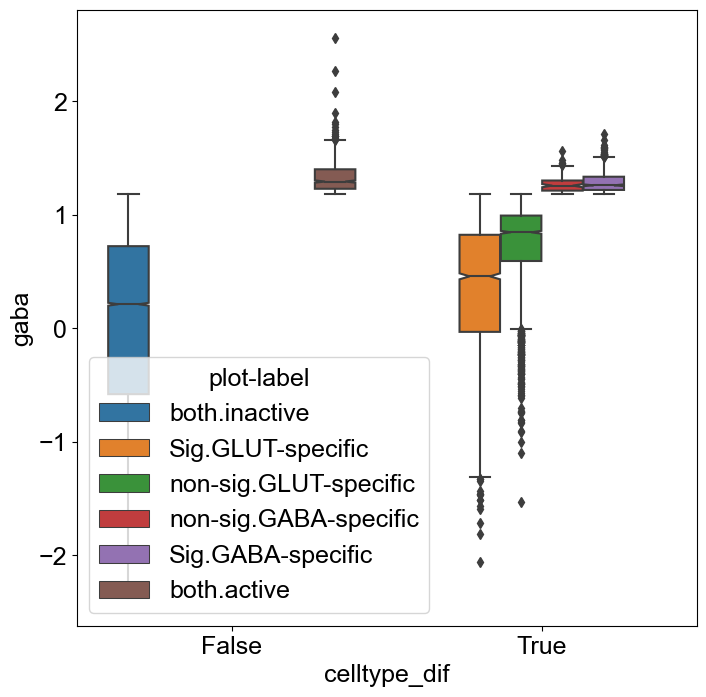

In [18]:
fig, ax=plt.subplots(figsize=(8,8))
sns.boxplot(x='celltype_dif', y="gaba", data=plot, notch=True, hue="plot-label")

## test gaba-active v. both active

GABA 
specific active n= 559 
mean= 1.290966837913304 
med= 1.2613573398600018 
IQR= 1.2203338656503488 1.336799853768934 

both n= 673 
mean= 1.33276158719975 
med= 1.2943922576014717 
IQR= 1.2306834875376624 1.4021970342946688 


mwu 157783.0 1.0788263816058607e-06 


GLUT 
specific active n= 2609 
mean= 1.5047339215219826 
med= 1.4308053471892748 
IQR= 1.0544036843288138 1.828694225688691 

both n= 673 
mean= 1.4588334705861592 
med= 1.2361296933922834 
IQR= 0.8981122075862763 1.886685501240419 


mwu 976080.0 7.526832568075804e-06 




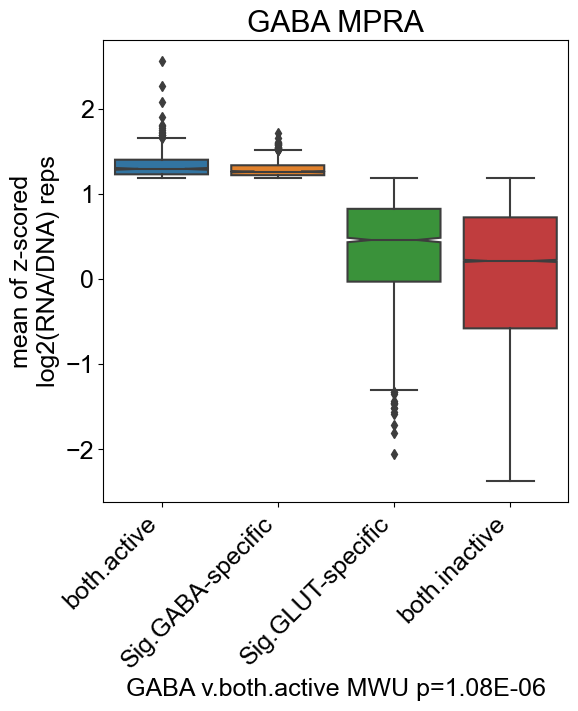

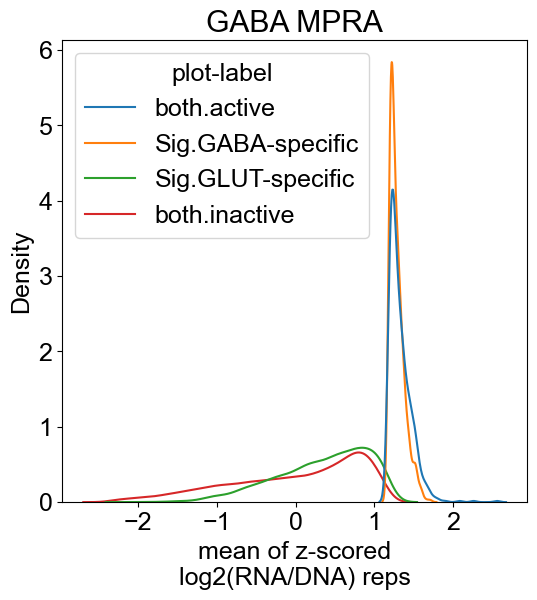

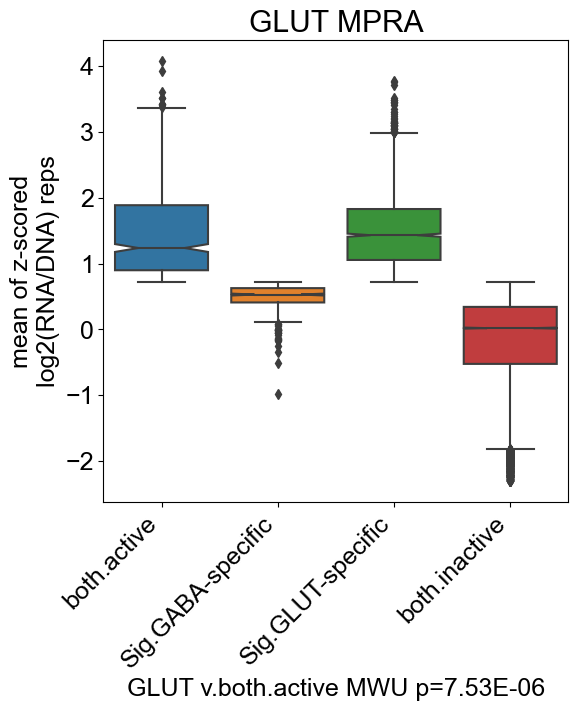

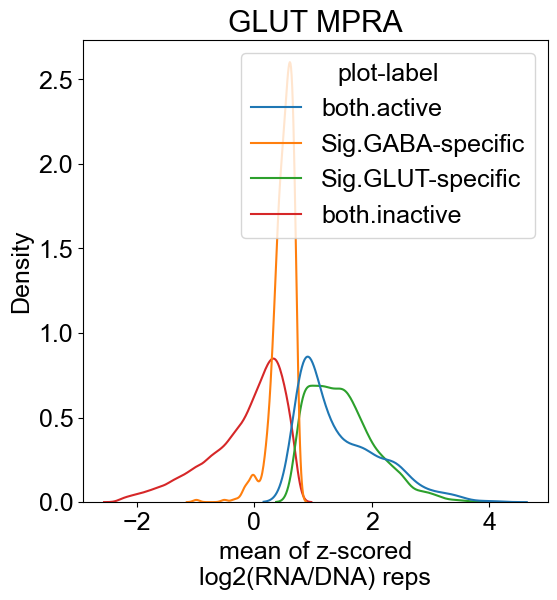

In [19]:
for CL in ["GABA", "GLUT"]:

    BOTH = "both.active"
    NULL = "both.inactive"

    if CL == "GABA":
        CL_LABEL = "Sig.GABA-specific"
        OTHER_CL = "Sig.GLUT-specific"
        cols = [BOTH, CL_LABEL, OTHER_CL, NULL]
    else:
        CL_LABEL = "Sig.GLUT-specific"
        OTHER_CL = "Sig.GABA-specific"
        cols = [BOTH, OTHER_CL, CL_LABEL, NULL]

    cell_specific = plot.loc[(plot["plot-label"] == CL_LABEL),
                             CL.lower()]

    other_cell = plot.loc[(plot["plot-label"] == OTHER_CL),
                          CL.lower()]

    both_active = plot.loc[(plot["plot-label"] == BOTH),
                           CL.lower()]
    both_inactive = plot.loc[(plot["plot-label"] == NULL),
                           CL.lower()]

    if CL == "GABA":
        medians = [round(np.median(both_active), 2),
                   round(np.median(cell_specific), 2),
                   round(np.median(other_cell), 2)]
        means = [round(np.mean(both_active), 2),

                 round(np.mean(cell_specific), 2),
                 round(np.mean(other_cell), 2),
                 ]
    else:
        medians = [round(np.median(both_active), 2),

                   round(np.median(other_cell), 2),
                   round(np.median(cell_specific), 2),
                   ]
        means = [round(np.mean(both_active), 2),
                 round(np.mean(other_cell), 2),
                 round(np.mean(cell_specific), 2),
                 ]

    print(CL, "\nspecific active n=", len(cell_specific),
          "\nmean=", np.mean(cell_specific),
          "\nmed=", np.median(cell_specific),
          "\nIQR=", np.quantile(cell_specific, 0.25), np.quantile(
              cell_specific, 0.75),
          "\n\nboth n=", len(both_active),
          "\nmean=", np.mean(both_active),
          "\nmed=", np.median(both_active),
          "\nIQR=", np.quantile(both_active, 0.25), np.quantile(both_active, 0.75), "\n")

    # mwu
    stat, p = stats.mannwhitneyu(cell_specific, both_active)
    print("\nmwu", stat, p, "\n\n")

    #
    fig, ax = plt.subplots(figsize=(6, 6))

    data = plot.loc[(plot['plot-label'].isin(cols))]

    box_plot = sns.boxplot(x='plot-label', y=CL.lower(), data=data,
                           #showfliers=False, 
                           notch=True,
                           order=cols)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    p_formatted = "{:.2E}".format(p)
    ax.set(title=f"{CL} MPRA",
           xlabel=f"{CL} v.both.active MWU p={p_formatted}",
           ylabel=f"mean of z-scored\nlog2(RNA/DNA) reps"
           )
    """
    for xtick in box_plot.get_xticks():
        box_plot.text(xtick, medians[xtick], medians[xtick],
                      horizontalalignment='center', size='x-small', color='k', weight='semibold')
    """

    plt.savefig(os.path.join(
        RE, f"both.celltype-specific.{CL}.MPRA.box.pdf"), bbox_inches="tight")

    fig, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(x=CL.lower(), data=data, hue="plot-label",
                hue_order=cols, common_norm=False)

    #ax.legend(bbox_to_anchor=(1,1))
    ax.set(xlabel=f"mean of z-scored\nlog2(RNA/DNA) reps", 
           title=f"{CL} MPRA",
            )
    plt.savefig(os.path.join(
        RE, f"both.celltype-specific.{CL}.MPRA.hist.pdf"), bbox_inches="tight")

In [20]:
data.groupby(["plot-label"])["gaba"].describe()

,count,mean,std,min,25%,50%,75%,max
plot-label,,,,,,,,
Sig.GABA-specific,559.0,1.290967,0.093691,1.185805,1.220334,1.261357,1.336800,1.712569
Sig.GLUT-specific,2609.0,0.351439,0.581075,-2.054094,-0.030382,0.458949,0.825017,1.183996
both.active,673.0,1.332762,0.141802,1.185723,1.230683,1.294392,1.402197,2.561723
both.inactive,26859.0,0.013274,0.837409,-2.373211,-0.579298,0.213215,0.724784,1.185328


In [21]:
data.groupby(["plot-label"])["glut"].describe()

,count,mean,std,min,25%,50%,75%,max
plot-label,,,,,,,,
Sig.GABA-specific,559.0,0.489096,0.193156,-0.985470,0.408416,0.528568,0.626117,0.717247
Sig.GLUT-specific,2609.0,1.504734,0.557871,0.719678,1.054404,1.430805,1.828694,3.772778
both.active,673.0,1.458833,0.687632,0.720015,0.898112,1.236130,1.886686,4.078259
both.inactive,26859.0,-0.155658,0.645170,-2.306050,-0.525349,0.018375,0.341035,0.719071


# cell-type-specific v. all active

/scratch/fongsl/ipykernel_2066638/2572378873.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active[cell_sp_col]=active["plot-label"].apply(lambda x: True if x==sig_cell_sp_col else False)


5.1672818408839195e-05
                         count      mean       std       min       25%  \
plot.cell-type_specific                                                  
False                    774.0  1.325160  0.136508  1.185723  1.227899   
True                     559.0  1.290967  0.093691  1.185805  1.220334   

                              50%      75%       max  
plot.cell-type_specific                               
False                    1.284729  1.38537  2.561723  
True                     1.261357  1.33680  1.712569  
1.3525014775843447e-186


/scratch/fongsl/ipykernel_2066638/2572378873.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active[cell_sp_col]=active["plot-label"].apply(lambda x: True if x==sig_cell_sp_col else False)


                          count      mean       std       min       25%  \
plot.cell-type_specific                                                   
False                    3214.0  1.130663  0.441013  0.719152  0.827829   
True                     2609.0  1.504734  0.557871  0.719678  1.054404   

                              50%       75%       max  
plot.cell-type_specific                                
False                    0.989615  1.273515  4.078259  
True                     1.430805  1.828694  3.772778  


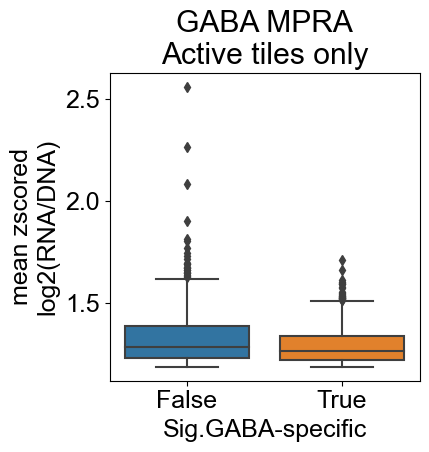

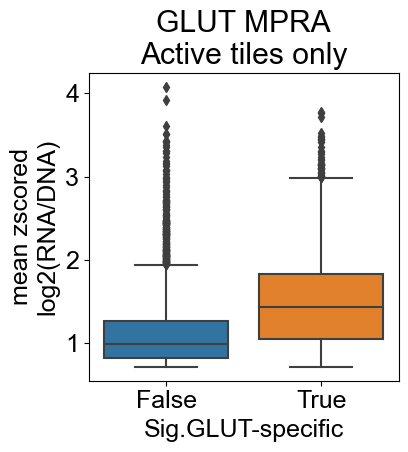

In [22]:
for CL in ["GABA", "GLUT"]:
    
    # subset only CL-MPRA active sequences
    active = plot.loc[plot[f"{CL.lower()}-label"]=="activating"]
    
    cell_sp_col="plot.cell-type_specific"
    sig_cell_sp_col=f"Sig.{CL}-specific"
    # label if active tile is CL-specific in CL MPRA
    active[cell_sp_col]=active["plot-label"].apply(lambda x: True if x==sig_cell_sp_col else False)

    fig, ax=plt.subplots(figsize=(4,4))
    sns.boxplot(y=CL.lower(), data=active, x=cell_sp_col)
    ax.set(title=f"{CL} MPRA\nActive tiles only", 
          ylabel = "mean zscored\nlog2(RNA/DNA)", 
          xlabel=sig_cell_sp_col)
    
    # save fig
    out = os.path.join(RE, f"{CL}.specific.sig.v.allActive.{CL}.MPRA.pdf")
    plt.savefig(out, bbox_inches='tight')
    
    # do stats
    cl_active = active.loc[active[cell_sp_col]==True, CL.lower()]
    all_other_active = active.loc[active[cell_sp_col]!=True, CL.lower()]
    s, p = stats.mannwhitneyu(cl_active, all_other_active)
    print(p)
    print(active.groupby(cell_sp_col)[CL.lower()].describe())

# Cell type sig difference - not active, necessarily

In [23]:
RE

'/wynton/group/ahituv/biomarin/results'

plot.sig.cell-type_specific         False         True 
count                        21650.000000  12405.000000
mean                            -0.067216      0.375430
std                              0.922534      0.816768
min                             -4.871012     -3.814399
25%                             -0.650869     -0.018209
50%                              0.127522      0.673186
75%                              0.674396      0.944337
max                              1.802622      2.561723
MannwhitneyuResult(statistic=176963050.0, pvalue=0.0)
plot.sig.cell-type_specific         False         True 
count                        21650.000000  12405.000000
mean                            -0.098219      0.325944
std                              0.866652      0.918582
min                             -5.682464     -4.808767
25%                             -0.587615     -0.089686
50%                              0.053761      0.311543
75%                              0.480273      0.6

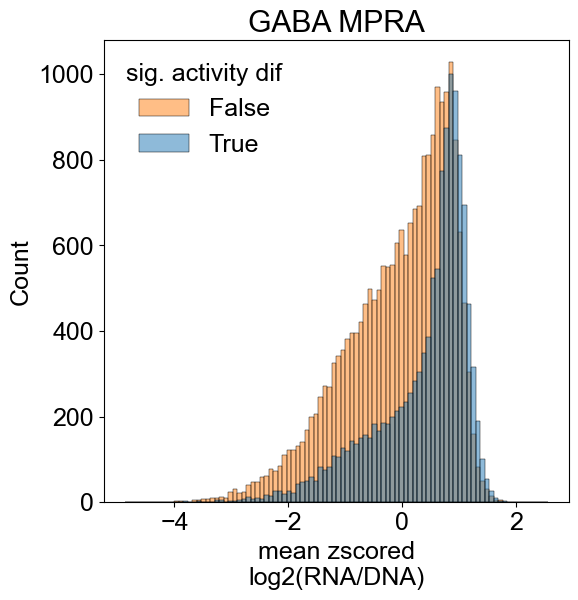

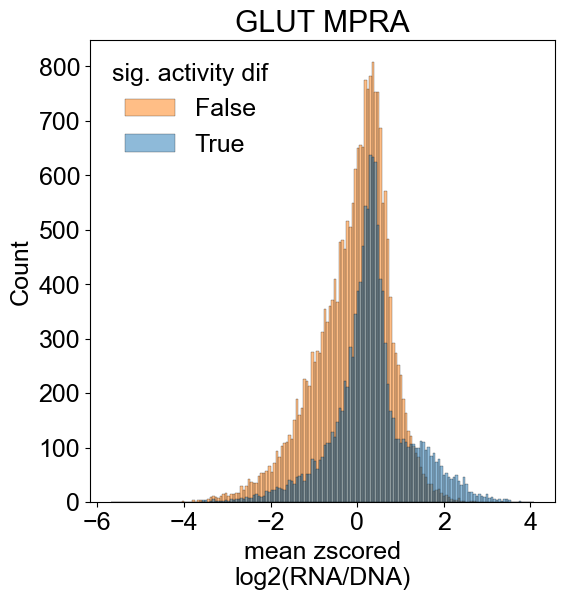

In [24]:
CONSIDER_DIRECTION = False
for CL in ["GABA", "GLUT"]:
    
    # subset only CL-MPRA plot sequences
    
    cell_sp_col="plot.sig.cell-type_specific"
    sig_cell_sp_col=f"Sig.{CL}-specific"
    
    # label if plot tile is CL-specific in CL MPRA
    if CONSIDER_DIRECTION is False:
        """
        cell-type-specific activity: activity scores are statistically significantly 
            different between GABA and GLUT environments
            
        This only considers if activity scores are significantly different between GABA and GLUT. 
        does not consider direction of effect. 
        """
        # label dataframe
        plot[cell_sp_col]=plot["sig"].apply(lambda x: True if x==True else False)
        
        # label for legend
        direction = "GABA != GLUT activity"
        direction = ''
        
        out = os.path.join(RE, f"any.cell.specific.sig.v.all.{CL}.MPRA.hist.pdf")
        
    elif CONSIDER_DIRECTION is True:
        """
        cell type specific activity: statistically significant difference in activity between GABA and GLUT 
            AND direction increases positively for seq in GABA MPRA, but not GLUT MPRA or vice versa
        """
       
        # Label direction of activity for cell_specific
        if CL == "GABA": 
            direction = 'positive GABA>negative GLUT'
            
        else:
            direction = 'positive GLUT>negative GABA'

        out = os.path.join(RE, f"{direction}.specific.sig.v.all.{CL}.MPRA.hist.pdf")

        direction_label = f"{direction}"

        # label dataframe
        plot.loc[(plot["sig"]==True) &
            (plot["direction"] == direction), cell_sp_col] = True
        plot.loc[(plot["sig"]==True) &
            (plot["direction"] != direction), cell_sp_col] = False
    
    fig, ax=plt.subplots(figsize=(6,6))
    
    sns.histplot(x=CL.lower(), data=plot, hue=cell_sp_col, hue_order=[True,False]
                )

    ax.set(title=f"{CL} MPRA", 
          xlabel = f"mean zscored\nlog2(RNA/DNA)", 
          )
    ax.legend([False, True], title=f"sig. activity dif", loc="upper left", frameon=False)
    
    # save fig
    plt.savefig(out, bbox_inches='tight')
    
    print(plot.groupby(cell_sp_col)[CL.lower()].describe().T)
    
    sig, notsig = plot.loc[plot[cell_sp_col]==True, CL.lower()], plot.loc[plot[cell_sp_col]!=True, CL.lower()]
    print(stats.mannwhitneyu(sig, notsig))

plot.sig.cell-type_specific         False       True 
count                        33496.000000  559.000000
mean                             0.074048    1.290967
std                              0.904876    0.093691
min                             -4.871012    1.185805
25%                             -0.490709    1.220334
50%                              0.326576    1.261357
75%                              0.792016    1.336800
max                              2.561723    1.712569
plot.sig.cell-type_specific         False        True 
count                        31446.000000  2609.000000
mean                            -0.063886     1.504734
std                              0.825074     0.557871
min                             -5.682464     0.719678
25%                             -0.476176     1.054404
50%                              0.104304     1.430805
75%                              0.450212     1.828694
max                              4.078259     3.772778


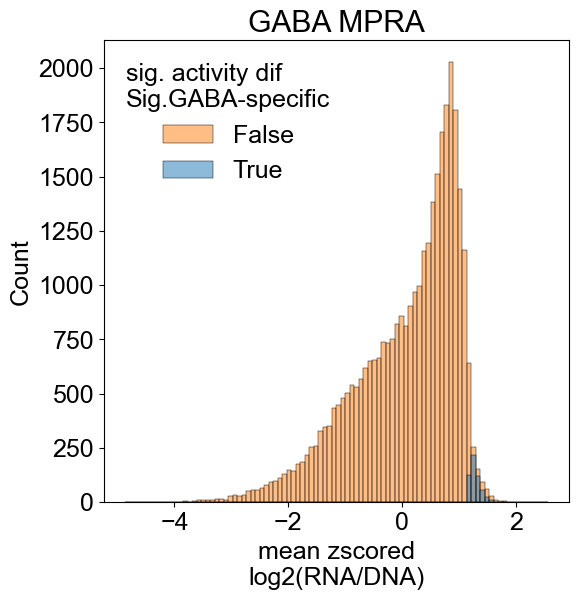

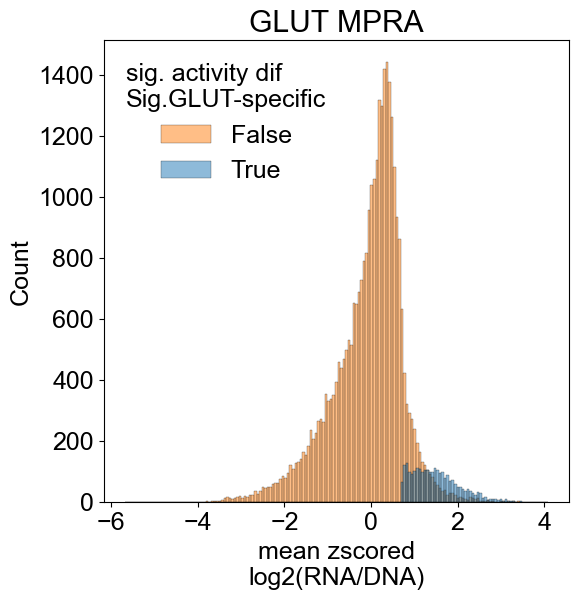

In [26]:
CONSIDER_DIRECTION = True
for CL in ["GABA", "GLUT"]:
    
    # subset only CL-MPRA plot sequences
    
    cell_sp_col="plot.sig.cell-type_specific"
    sig_cell_sp_col=f"Sig.{CL}-specific"
    
    # label if plot tile is CL-specific in CL MPRA
    if CONSIDER_DIRECTION is False:
        """
        cell-type-specific activity: activity scores are statistically significantly 
            different between GABA and GLUT environments
            
        This only considers if activity scores are significantly different between GABA and GLUT. 
        does not consider direction of effect. 
        """
        # label dataframe
        plot[cell_sp_col]=plot["sig"].apply(lambda x: True if x==True else False)
        
        # label for legend
        direction_label = "GABA != GLUT activity"
        
        out = os.path.join(RE, f"any.cell.specific.sig.v.all.{CL}.MPRA.hist.pdf")
        
    elif CONSIDER_DIRECTION is True:
        """
        cell type specific activity: statistically significant difference in activity between GABA and GLUT 
            AND direction increases positively for seq in GABA MPRA, but not GLUT MPRA or vice versa
        """
       
        # Label direction of activity for cell_specific
        if CL == "GABA": 
            direction = 'positive GABA>negative GLUT'
            
        else:
            direction = 'positive GLUT>negative GABA'

        out = os.path.join(RE, f"{direction}.specific.sig.v.all.{CL}.MPRA.hist.pdf")

        direction_label = f"{direction}"

        # label dataframe
        plot.loc[(plot["sig"]==True) &
            (plot["plot-label"] == sig_cell_sp_col), cell_sp_col] = True
        plot.loc[(plot["sig"]==True) &
            (plot["plot-label"] != sig_cell_sp_col), cell_sp_col] = False
    
    fig, ax=plt.subplots(figsize=(6,6))
    
    sns.histplot(x=CL.lower(), data=plot, hue=cell_sp_col, hue_order=[True,False]
                )

    ax.set(title=f"{CL} MPRA", 
          xlabel = f"mean zscored\nlog2(RNA/DNA)", 
          )
    ax.legend([False, True], title=f"sig. activity dif\n{sig_cell_sp_col}", loc="upper left", frameon=False)
    
    # save fig
    plt.savefig(out, bbox_inches='tight')
    print(plot.groupby(cell_sp_col)[CL.lower()].describe().T)
    sig, notsig = plot.loc[plot[cell_sp_col]==True, CL.lower()], plot.loc[plot[cell_sp_col]!=True, CL.lower()]